In this notebook, we introduce:

- __Convolutions__ and examples of simple __image filters__ to motivate the construction of __Convolutionlal Neural Networks.__
- Example: CNN on Mnist
    - Visualizing Data
    - Constructing simple Convolutional Neural Networks
    - Training and Inference
    - Visualizing/Interpreting trained Neural Nets
- Example: CNN on CIFAR-10

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from scipy import misc
import os
import time
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import tensorflow.keras as keras
    

2023-11-13 19:07:42.273150: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 19:07:42.273783: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 19:07:42.290099: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 19:07:43.594953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# [Convolutional Neural Network](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=e26cc4a1c717653f323715d751c8dea7461aa105)
CNN is a type of deep learning model for processing data that has a grid pattern, such as images.

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the images directly to the model.
    - The two Conv2D layers below learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.
## The Initiative

## Model Structure


![conv layer](images/conv_layer.png)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)
![conv layer](images/conv.png)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)

<img src="images/MaxpoolSample2.png" width="600" hight="600" align="left"/>

![CNN](https://anhvnn.files.wordpress.com/2018/02/convolve.png?w=1000)

For a filter of size $N \times N$ applied to an image of size $W \times H$, with padding $P$ and stride $S$, the output tensor will have the dimensions:

\begin{align}
\ (\frac{W - N + 2P}{S} + 1) \times (\frac{H - N + 2P}{S} + 1) \\
\end{align}

Let's apply a basic convolution on a Gray Scale image. We will iterate over the image, leaving a 1 pixel margin, and multiply out each of the neighbors of the current pixel by the corresponding value in the filter, and then sum them up to produce the activation value in the resulting tensor.

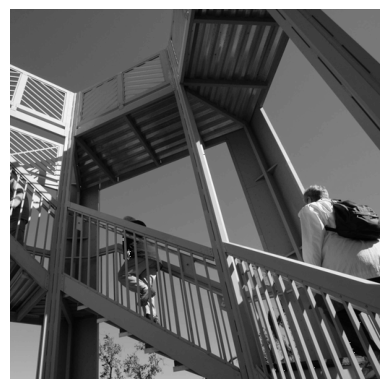

In [2]:
img = misc.ascent()
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(img)
plt.show()

In [3]:
def simple_convolution(img, filter):
    output = np.copy(img)
    size_x, size_y = img.shape
    for x in range(1,size_x-1):
        for y in range(1,size_y-1):
            convolution = 0.0
            convolution = convolution + (img[x - 1, y-1] * filter[0][0])
            convolution = convolution + (img[x, y-1] * filter[0][1])
            convolution = convolution + (img[x + 1, y-1] * filter[0][2])
            convolution = convolution + (img[x-1, y] * filter[1][0])
            convolution = convolution + (img[x, y] * filter[1][1])
            convolution = convolution + (img[x+1, y] * filter[1][2])
            convolution = convolution + (img[x-1, y+1] * filter[2][0])
            convolution = convolution + (img[x, y+1] * filter[2][1])
            convolution = convolution + (img[x+1, y+1] * filter[2][2])
            if(convolution<0):
                convolution=0
            if(convolution>255):
                convolution=255
            output[x, y] = convolution
    return output

In [4]:
#Experiment with different filters to see the effects.

filter = [ [-1, -2, -1], [0, 0, 0], [1, 2, 1]]      #vertical edge detector  (bottom sobel )
#filter = [ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]      #horizontal edge detector (right sobel)

#filter = [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]  #outline
#filter = [[0, -1, 0], [-1, 5, -1], [0, -1, 0]]      #sharpen
#filter = [[-2, -1, 0], [-1, 1, 1], [0, 1, 2]]       #emboss

Text(0.5, 1.0, 'Output')

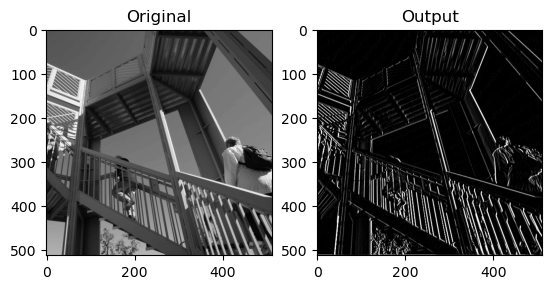

In [5]:
output = simple_convolution(img, filter)

plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(output, 'gray')
plt.title('Output')

The ides is that in a deep convolutional net, the various filters in each layer sort of act like learned filters that extract features from the input image/tensor layer, and its through combination of these features that the network learns to classify images, detect objects, etc

**Max Pooling**

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" alt="MaxPooling" style="width: 400px;"/>

**A complete CNN**

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

# Mnist dataset

In [6]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


__One hot encoding:__

\begin{align}
    0 = \begin{bmatrix}
           1 \\
           0 \\
           0 \\
           \vdots \\
           0
         \end{bmatrix}, \hspace{1cm}
    1 = \begin{bmatrix}
           0 \\
           1 \\
           0 \\
           \vdots \\
           0
         \end{bmatrix}, \hspace{1cm}
    2 = \begin{bmatrix}
           0 \\
           0 \\
           1 \\
           \vdots \\
           0
         \end{bmatrix}, \hspace{1cm} ..., \hspace{1cm}
    9 = \begin{bmatrix}
           0 \\
           0 \\
           0 \\
           \vdots \\
           1
         \end{bmatrix}
  \end{align}

<img src="http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png" style="width: 600px;"/>

### Visualize a sample of Training Data 

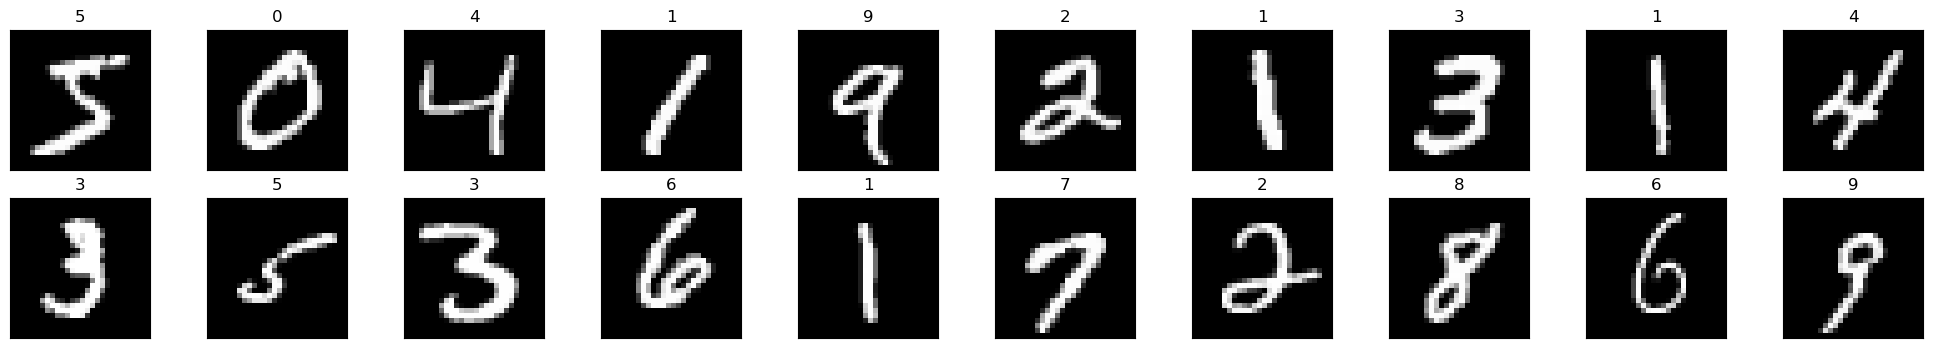

In [7]:
# obtain one batch of training images
images, labels = train_images[:20], train_labels[:20]


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    ax.set_title(str(np.argmax(labels[idx])))

### View an Image in More Detail 

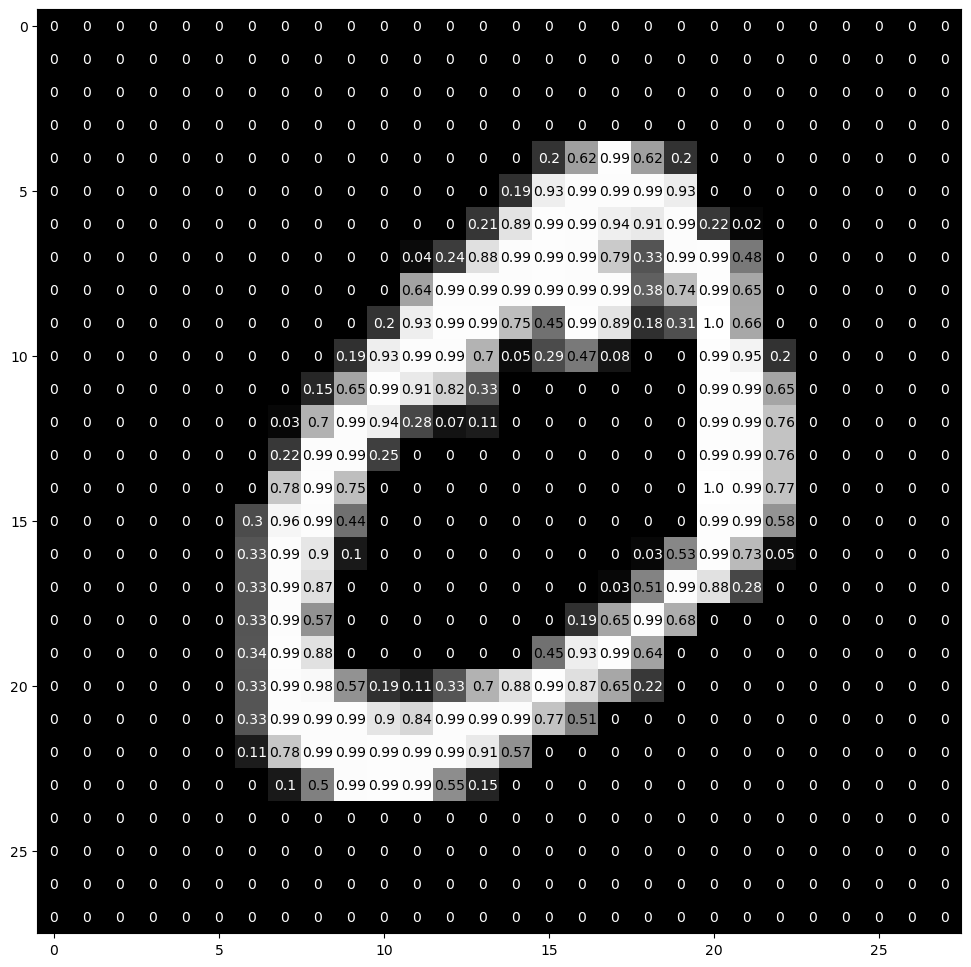

In [8]:
img = np.squeeze(train_images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture

The 6 lines of code below show you what a basic convnet looks like. It's a stack of Conv2D and MaxPooling2D layers. We'll see in a minute what they do concretely. Importantly, a convnet takes as input tensors of shape (image_height, image_width, image_channels) (not including the batch dimension). In our case, we will configure our convnet to process inputs of size (28, 28, 1), which is the format of MNIST images. We do this via passing the argument input_shape=(28, 28, 1) to our first layer.

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

2023-11-13 19:08:39.578810: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43449 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:46:00.0, compute capability: 8.6


Let's display the architecture of our convnet so far:

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55744 (217.75 KB)
Trainable params: 55744 

You can see above that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to the Conv2D layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape (3, 3, 64)) into a densely-connected classifier network like those you are already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. So first, we will have to flatten our 3D outputs to 1D, and then add a few Dense layers on top:

In [11]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network looks like:

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576,), before going through two Dense layers.

Now, let's train our convnet on the MNIST digits. 

## Compile and Train

In [13]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


<img src="https://miro.medium.com/max/800/1*vpCRPR2o3tTl6R3JiRcvyQ.png" style="width: 300px;"/>

__Optimizer__: RMSprop (Root Mean Square Prop) and many other optimizers are "*different flavors*" of gradient descent. RMSprop is given by:

\begin{align}
\ S_{dW} &= \beta_{S_{dW}} + (1 - \beta)(\frac{\partial{J}}{\partial{W}})^2\\
\ W &= W - \alpha \frac{\frac{\partial{J}}{\partial{W}}}{\sqrt{S_{dW}}+ \epsilon}\\
\end{align}

where: 

- s  - the exponentially weighted average of past squares of gradients
- $\frac{\partial{J}}{\partial{W}}$ - cost gradient with respect to current layer weight tensor
- W  - weight tensor
- β - hyperparameter to be tuned
- α  - the learning rate
- ϵ - very small value to avoid dividing by zero

__ReLU ( Rectified Linear Unit )__:  $$f(x) = max(0, x)$$


__Some common activation functions__:

<img src='images/activations.png' alt="a few common activation functions" style="width: 500px;">

__Softmax Function__: 

\begin{align}
\ p_i &=  \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}},   \quad  \text{for i = 1, ... , k} 
\end{align}

__Categorical Crossentropy__: Loss function widely used for multiclass classification. It is give by:

\begin{align}
\ L &= - \sum_i y_i \log{p_i}
\end{align}

where $y_i$ is the true class and $p_i$ is the predicted *probability/score* for the true class.

You can read more about Optimizers and Loss Functions [here](http://cs231n.github.io/linear-classify/)

__Training Loop__:

The steps for training/learning from a batch of data are :

1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Keras wraps up all of these steps in one function: `model.fit()`. In the following we train for 5 epochs with a batch size of 64. Notice how the loss decreases and accuracy increases as we train.

In [14]:
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5


2023-11-13 19:08:42.651553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900
2023-11-13 19:08:52.448562: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f298c009f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 19:08:52.448595: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2023-11-13 19:08:52.552749: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 19:08:53.100071: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 [==============================] - 23s 3ms/step - loss: 0.1783 - accuracy: 0.9441
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0476 - accuracy: 0.9852
Epoch 3/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0327 - accuracy: 0.9903
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0241 - accuracy: 0.9924
Epoch 5/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0189 - accuracy: 0.9942


## Test the Trained Network

Finally, we test our trained model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [15]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('Test Accuracy: {:.4f} and Test Loss: {:.4f}'.format(test_acc, test_loss))

Test Accuracy: 0.9916 and Test Loss: 0.0325


In [16]:
# initialize lists to monitor test accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

pred = model.predict(test_images, verbose=0)
pred = np.argmax(pred, axis=-1)
labels = np.argmax(test_labels, axis=-1)

for i in range(len(pred)):
    correct = pred[i] == labels[i]
    class_correct[labels[i]] += correct
    class_total[labels[i]] += 1
    
    
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))  

Test Accuracy of     0: 99% (975/980)
Test Accuracy of     1: 99% (1133/1135)
Test Accuracy of     2: 98% (1012/1032)
Test Accuracy of     3: 99% (1004/1010)
Test Accuracy of     4: 99% (977/982)
Test Accuracy of     5: 98% (882/892)
Test Accuracy of     6: 98% (948/958)
Test Accuracy of     7: 99% (1018/1028)
Test Accuracy of     8: 99% (971/974)
Test Accuracy of     9: 98% (996/1009)

Test Accuracy (Overall): 99% (9916/10000)


Lets see predictions on individual test images. Since `model.predict` expects a batch of images, i.e, a 4-d tensor, we expand the first dimension of the test image before feeding into model.

1/1 [==============================] - 0s 393ms/step


Text(0.5, 1.0, 'Prediction: 7')

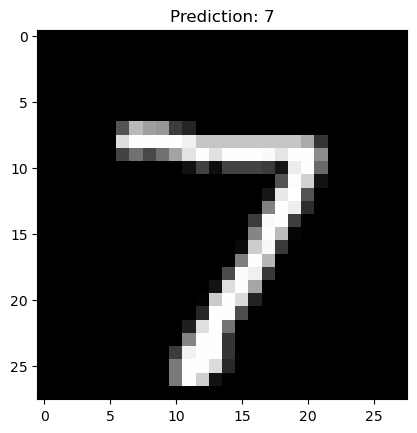

In [17]:
index = 0
pred = model.predict(np.expand_dims(test_images[index], axis=0)); pred = np.argmax(pred)
plt.imshow(np.squeeze(test_images[index]), cmap='gray')
plt.title('Prediction: {}'.format(pred))

In [18]:
#Define a python generator [More on Generators in cifar-10 notebook]
import itertools

def generator(images, labels, batch_size):
    iterable_1 = iter(images)
    iterable_2 = iter(labels)
    while True:
        l1 = tuple(itertools.islice(iterable_1, 0, batch_size))
        l2 = tuple(itertools.islice(iterable_2, 0, batch_size))
        if l1 and l2:
            yield np.vstack(np.expand_dims(l1, axis=0)), np.vstack(np.expand_dims(l2, axis=0))
        else:
            break
            
test_generator = generator(test_images, test_labels, 20)

1/1 [==============================] - 0s 45ms/step


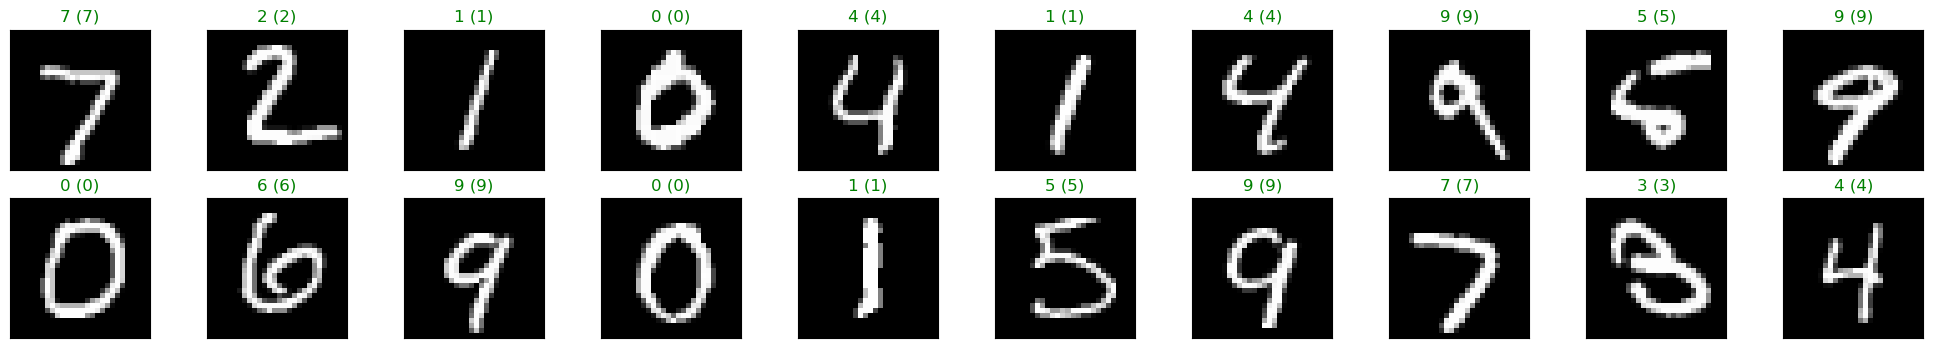

In [19]:
images, labels = next(test_generator)
labels = np.argmax(labels, axis=-1)

# get sample outputs
preds = model.predict(images)
# convert output probabilities to predicted class
preds = np.argmax(preds, axis=-1)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

313/313 [==============================] - 0s 899us/step


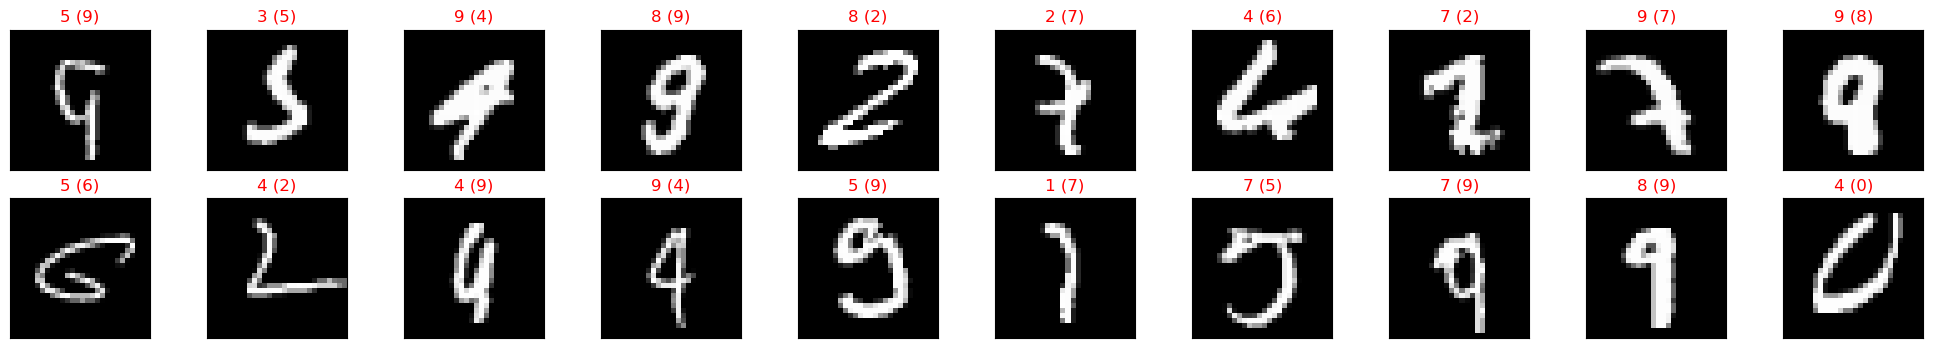

In [20]:
# A sample of Incorrect Predictions
preds = np.argmax(model.predict(test_images), axis=-1)
labels = np.argmax(test_labels, axis=-1)
incorrect_idxs = np.where( preds != labels )[0]

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    idx = incorrect_idxs[i]
    ax = fig.add_subplot(2, 20//2, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Interpret

### Visualizing second-last-layer Activations

In [21]:
from tensorflow.keras import Model

emb_model = Model(inputs = model.input, outputs = model.get_layer('dense').output)

In [22]:
emb_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928 

In [23]:
activations = emb_model.predict(test_images, verbose=1)
predictions = model.predict(test_images, verbose=1); labels = predictions.argmax(axis=-1)

313/313 [==============================] - 0s 892us/step


In [24]:
activations.shape

(10000, 64)

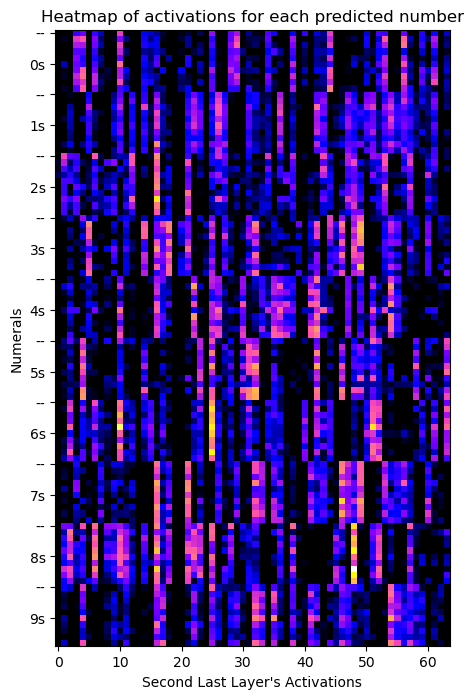

In [25]:
# Stack 10 examples of activation vectors for each numeral
seq = []
for i in range(10):
    seq.append(activations[labels==i][:10])
seq = np.vstack(seq)


# Plot heatmap for the example activations
plt.figure(figsize=(8,8))
plt.imshow(seq, interpolation='nearest', cmap=plt.cm.gnuplot2)
plt.yticks(np.arange(0,100, 5), ['--','0s','--','1s','--','2s','--','3s','--','4s','--','5s','--','6s',
                                 '--','7s','--','8s','--','9s'])
plt.xlabel("Second Last Layer's Activations")
plt.ylabel('Numerals')
plt.title('Heatmap of activations for each predicted number')
plt.show()

### Visualizing intermediate-layer activations

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

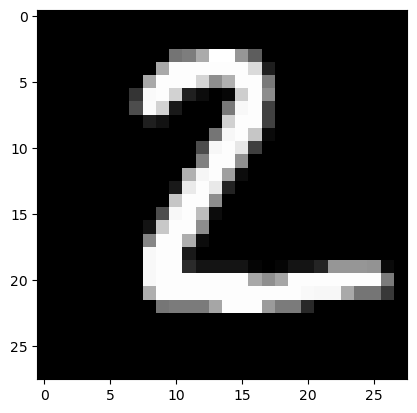

In [27]:
img = test_images[1]
img = np.expand_dims(img, axis=0)

plt.imshow(np.squeeze(img), cmap='gray')

In [28]:
from tensorflow.keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [29]:
# This will return a list of 8 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img)

1/1 [==============================] - 1s 746ms/step


In [30]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 26, 26, 32)


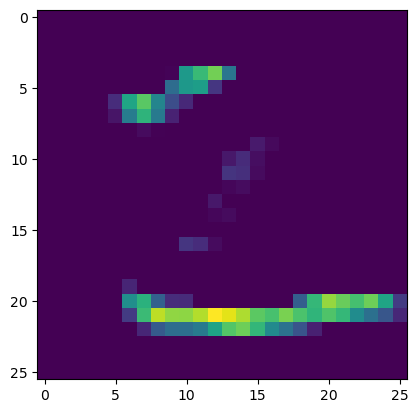

In [31]:
plt.imshow(first_layer_activation[0, :, :, 6], cmap='viridis')
plt.show()

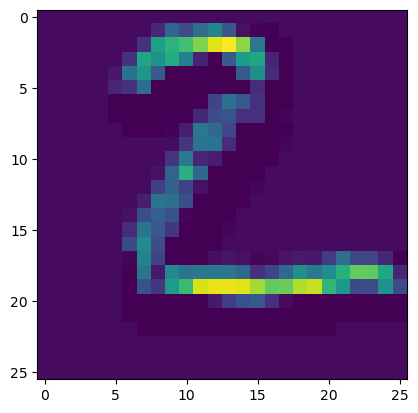

In [32]:
plt.imshow(first_layer_activation[0, :, :, 12], cmap='viridis')
plt.show()

/tmp/ipykernel_3569123/1274607799.py:28: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
/tmp/ipykernel_3569123/1274607799.py:31: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


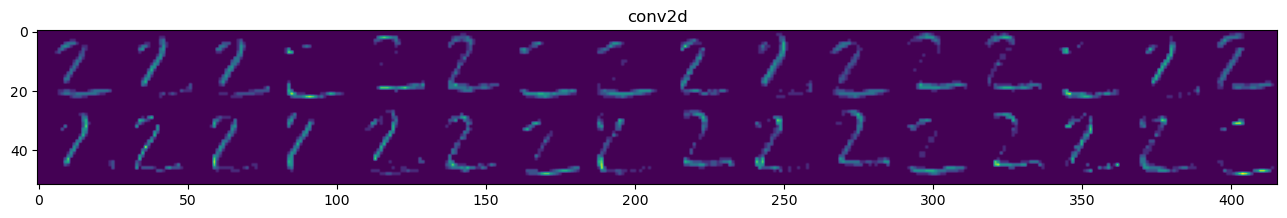

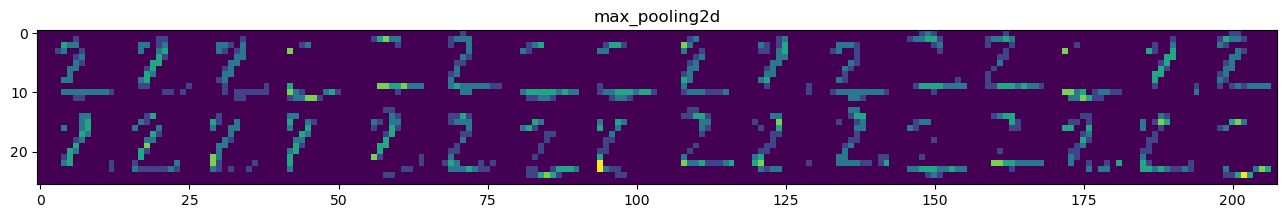

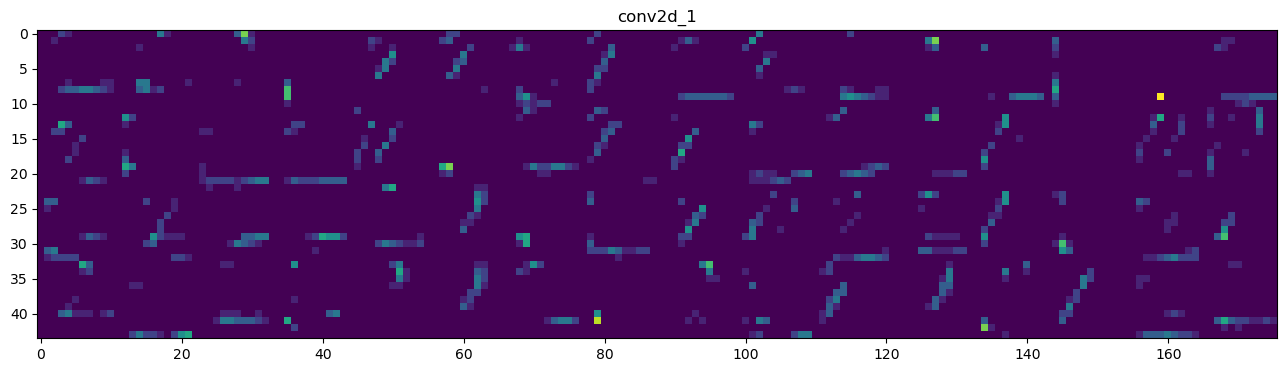

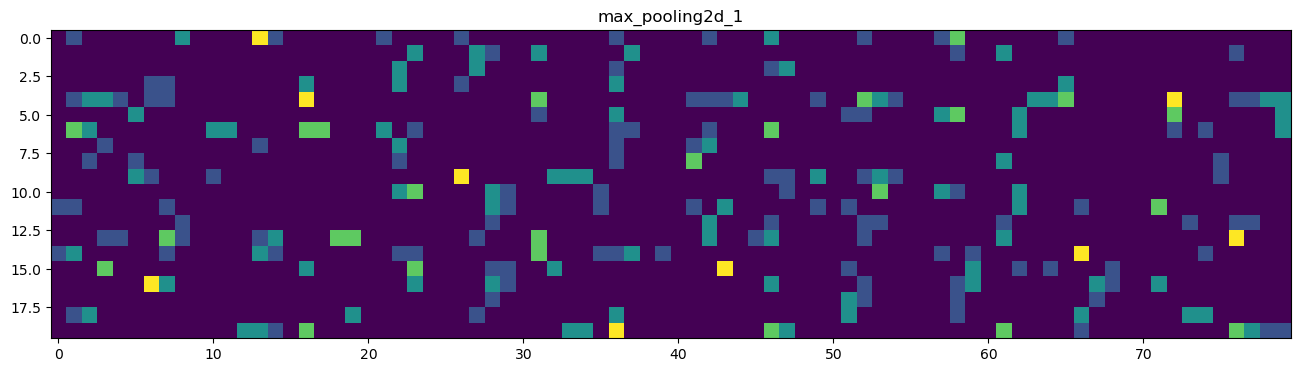

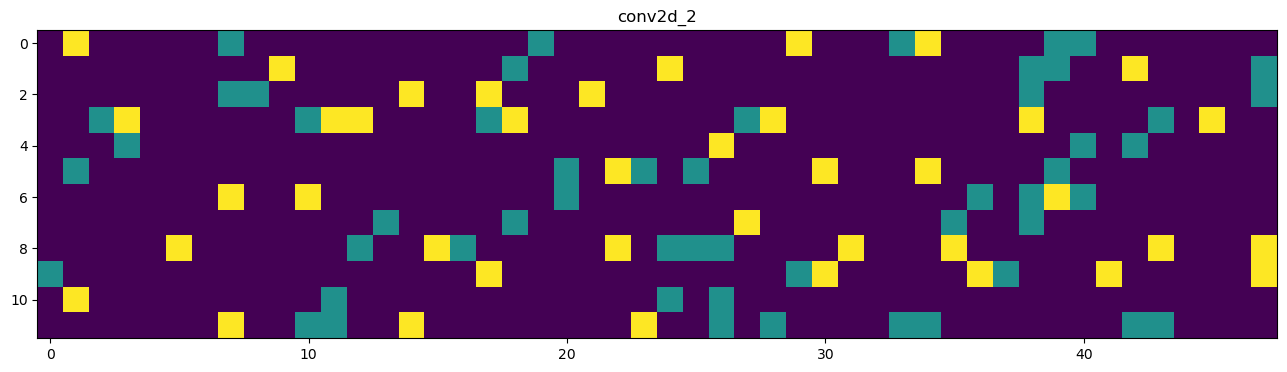

In [33]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            #channel_image *= 64
            #channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Also see: [Visualizing and Understanding Convolutional Networks, Zeiler et. al.](https://arxiv.org/pdf/1311.2901.pdf)

### Visualizing heatmap of class activation 

To visualize which parts of our image were the most "prediction"-like, let's set up the Grad-CAM process.

"Class Activation Map" (CAM) is a visualization technique which is useful for understanding which parts of a given image led a convnet to its final classification decision, by producing heatmaps of "class activation" over input images.

You can read more about this technique here: [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via Gradient-based Localization.](https://arxiv.org/abs/1610.02391)

<img src="https://miro.medium.com/max/3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png" alt="MNIST CNN" style="width: 600px;"/> (src: Towards Data Science)

In [34]:
import tensorflow.keras.backend as K
import cv2

In [35]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [36]:
def get_superimposed_img(img, heatmap):
    im = np.array(np.squeeze(img) * 255, dtype = np.uint8)
    cv2.imwrite('test_img.jpg', im)

    # We use cv2 to load the original image
    img = cv2.imread('test_img.jpg', 0)

    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # 0.9 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.9 + img

    # Save the image to disk
    cv2.imwrite('test_img_cam.jpg', superimposed_img)
    
    cam = cv2.imread('test_img_cam.jpg', 0)
    return cam, heatmap

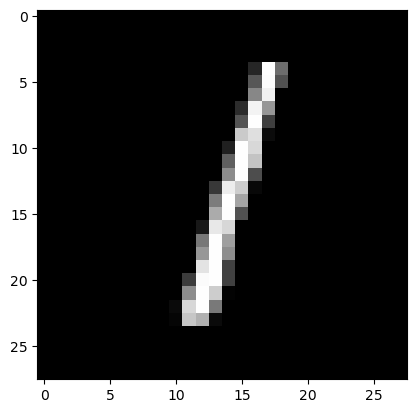

In [37]:
img = test_images[2]
img = np.expand_dims(img, axis=0)
plt.imshow(np.squeeze(img))

1/1 [==============================] - 0s 19ms/step


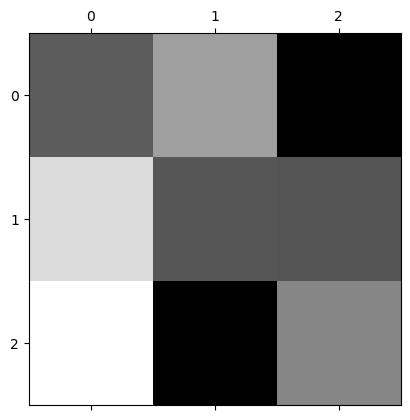

In [38]:
last_conv_layer_name = "conv2d_2" 

# Remove last layer's softmax
model.layers[-1].activation = None

# What the top predicted class is
preds = model.predict(img)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [39]:
cam, heatmap = get_superimposed_img(img, heatmap)

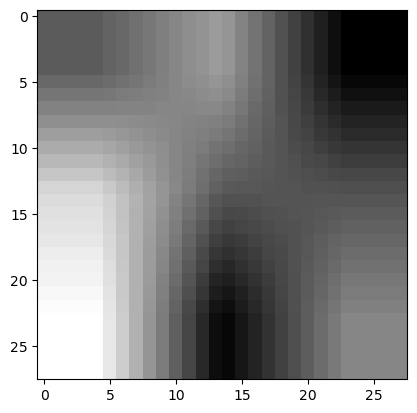

In [40]:
plt.imshow(heatmap)

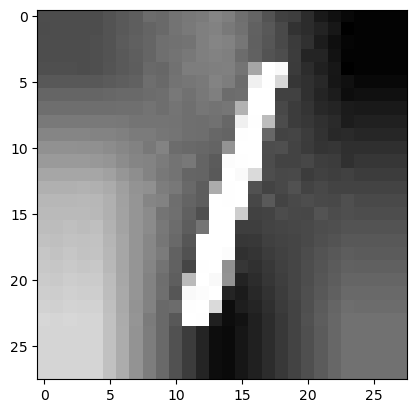

In [41]:
plt.imshow(cam)

In [42]:
cams, heatmaps = [], []

for i in range(280,291):
    
    img = test_images[i]
    img = np.expand_dims(img, axis=0)
    
    preds = model.predict(img)
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
        
    cam, heatmap = get_superimposed_img(img, heatmap)
    
    cams.append(cam)
    heatmaps.append(heatmap)

1/1 [==============================] - 0s 18ms/step


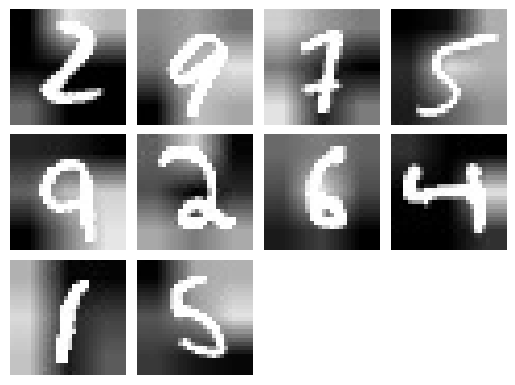

In [43]:
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.axis('Off')
    plt.subplots_adjust(wspace=0.1,hspace=0.05)
    plt.imshow(cams[i])

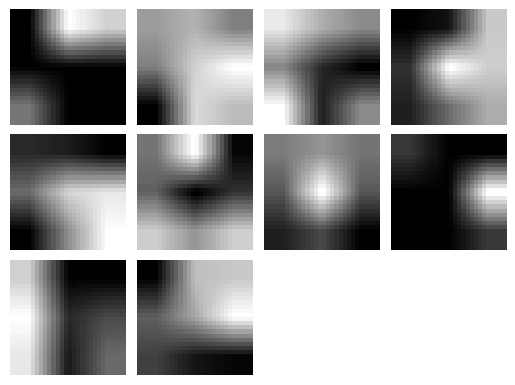

In [44]:
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.axis('Off')
    plt.subplots_adjust(wspace=0.1,hspace=0.05)
    plt.imshow(heatmaps[i])

# [The CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Here are the classes in the dataset, as well as 10 random images from each: 

<div>
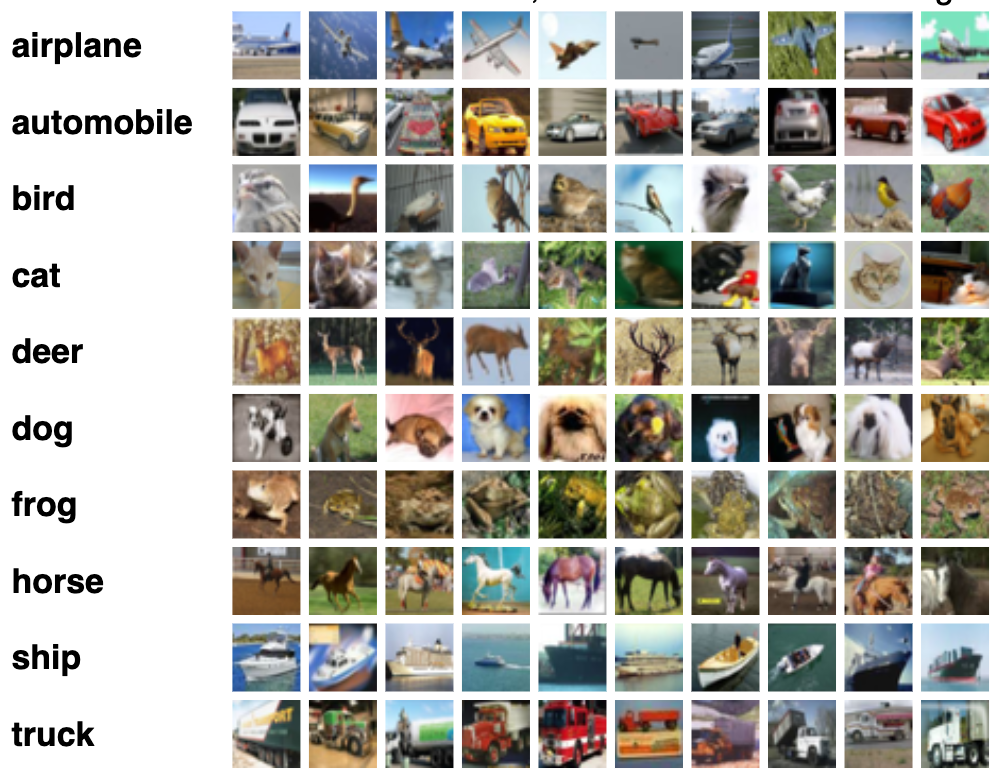
</div>

In [45]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(np.float32)
x_test  = x_test.astype(np.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(np.int32)
y_test  = y_test.astype(np.int32)

print()
print('CIFAR-10 data loaded: train:',len(x_train),'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)


CIFAR-10 data loaded: train: 50000 test: 10000
X_train: (50000, 32, 32, 3)
y_train: (50000, 1)


This time we won't flatten the images upfront. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

<img src="images/image_representation.png"  align="left"/>

In [46]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [47]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [48]:
# This took 43 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/3


2023-11-13 19:09:24.698907: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incifar10_classifier/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


98/98 [==============================] - 4s 13ms/step - loss: 1.8930 - accuracy: 0.3029
Epoch 2/3
98/98 [==============================] - 1s 10ms/step - loss: 1.5218 - accuracy: 0.4472
Epoch 3/3
98/98 [==============================] - 1s 9ms/step - loss: 1.3907 - accuracy: 0.4983


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

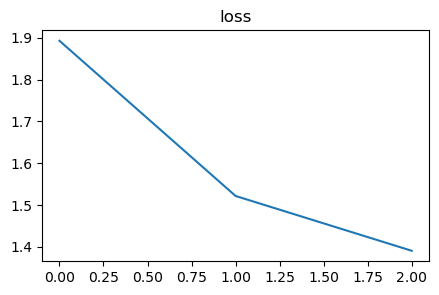

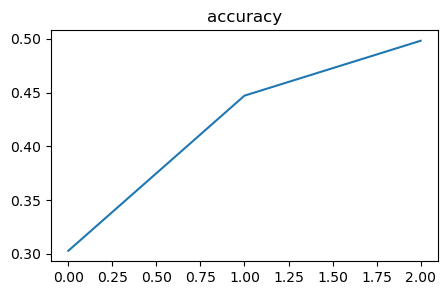

In [49]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

With enough training epochs, the test accuracy should exceed 96.53%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). 

In [50]:
%%time
x_test_reshaped = np.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 1s - loss: 1.2023 - accuracy: 0.5838 - 510ms/epoch - 2ms/step
accuracy: 58.38%
CPU times: user 697 ms, sys: 88 ms, total: 785 ms
Wall time: 637 ms


We can also again check the confusion matrix

In [51]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 0s 921us/step
[[622  43  87  11   9   6  15  10 165  32]
 [ 27 770   6  10   2   3  15   7  59 101]
 [ 89  17 454  51 124  92  88  35  31  19]
 [ 16  14 129 327  74 237 122  34  19  28]
 [ 39  10 187  51 434  41 142  74  16   6]
 [ 20   6 133 145  68 504  43  60  14   7]
 [  9   8  72  59  83  24 717   8   8  12]
 [ 21   9  49  51  71  91  24 644  11  29]
 [ 94  60  20  10   2   7  14   6 758  29]
 [ 34 181  15  14   3   4  28  25  88 608]]

Classification accuracy for each class:

0: 0.6220
1: 0.7700
2: 0.4540
3: 0.3270
4: 0.4340
5: 0.5040
6: 0.7170
7: 0.6440
8: 0.7580
9: 0.6080


### More verbose training

This approach explicitly handles the looping over data. It will be helpful in future for diving in and optimizing

In [52]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [53]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [54]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [55]:
def train_network(_batch_size, _n_training_epochs, _lr):

    cifar_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, cifar_model, opt)

In [56]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 1.9 seconds for epoch #0
beginning epoch 1
took 0.8 seconds for epoch #1
beginning epoch 2
took 0.8 seconds for epoch #2


# Exercise

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning rate, altering the number of neurons the hidden layer, chnaging the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 60.80%, although it varies randomly.

In [1]:
# class CIFAR10Classifier(tf.keras.models.Model):

#     def __init__(self, activation=tf.nn.tanh):
#         tf.keras.models.Model.__init__(self)

#         self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
#         self.conv_2 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
#         self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
#         self.drop_4 = tf.keras.layers.Dropout(0.2)
#         self.conv_5 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
#         self.conv_6 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
#         self.pool_7 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
#         self.drop_8 = tf.keras.layers.Dropout(0.2)
#         self.conv_9 = tf.keras.layers.Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
#         self.conv_10 = tf.keras.layers.Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
#         self.pool_11 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
#         self.drop_12 = tf.keras.layers.Dropout(0.2)
#         self.dense_13 = tf.keras.layers.Dense(128, activation='relu')
#         self.drop_14 = tf.keras.layers.Dropout(0.2)
#         self.dense_15 = tf.keras.layers.Dense(10, activation='softmax')
        

#     def call(self, inputs):

#         x = self.conv_1(inputs)
#         x = self.conv_2(x)
#         x = self.pool_3(x)
#         x = self.drop_4(x)
        
#         x = self.conv_5(x)
#         x = self.conv_6(x)
#         x = self.pool_7(x)
#         x = self.drop_8(x)
        
        
#         x = self.conv_9(x)
#         x = self.conv_10(x)
#         x = self.pool_11(x)
#         x = self.drop_12(x)
        
        
#         x = tf.keras.layers.Flatten()(x)
#         x = self.dense_13(x)
#         x = self.drop_14(x)
#         x = self.dense_15(x)

#         return x

In [2]:
# def train_network_concise(_batch_size, _n_training_epochs, _lr):

#     cnn_model = CIFAR10Classifier()

#     cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
#     history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
#     return history, cnn_model

In [3]:
# batch_size = 64
# epochs = 10
# lr = .01
# history, cnn_model = train_network_concise(batch_size, epochs, lr)

In [4]:
# plt.figure(figsize=(5,3))
# plt.plot(history.epoch,history.history['loss'])
# plt.title('loss')

# plt.figure(figsize=(5,3))
# plt.plot(history.epoch,history.history['accuracy'])
# plt.title('accuracy');


In [5]:
# %%time
# x_test_reshaped = np.expand_dims(x_test, -1)
# scores = cnn_model.evaluate(x_test, y_test, verbose=2)
# print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))